<a href="https://colab.research.google.com/github/samato88/PALNI/blob/main/PALNI_FilterDataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Memory check, just FYI
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')



Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
#@title import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title imports
!pip install ipdb
!pip install xlsxwriter
!pip install openpyxl
import os
import sys
if 'google.colab' in sys.modules:
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/Includes/')
import ipdb
import re
import time
from datetime import datetime
from zoneinfo import ZoneInfo
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import csv
import numpy as np
from openpyxl.utils.dataframe import dataframe_to_rows
import altair as alt
import pdb # ipdb not so hot in colab - goes into libraries regardless of 'n'



start_time = time.time()

now = datetime.now()
pacific_tz = ZoneInfo('America/Los_Angeles')
now_pacific = now.astimezone(pacific_tz)
print(f"Starting at: {now_pacific.strftime('%Y-%m-%d %H:%M:%S')}")
#print("Starting at:", datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')) # Convert to a datetime object - utc

Starting at: 2025-05-08 11:16:48


In [4]:
#@title code to skip cells
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [5]:
#@title Is this a test run?
testing = False
cloud = True

if not cloud:
    fields = "/Users/samato/Dropbox/EAST/Gold_Rush/Post-2010-Group-Collection-Analysis-2023/GR_Reports/Fields.xlsx"
    libmetadata = "/Users/samato/Dropbox/EAST/Gold_Rush/Comparisons/Scripts/Member_Metadata.xlsx";  #0:instID, 1:lib, 2:GRLibName, 3:State, 4:Sym, 5:CollSize, 6:Retentions, 7:%, 8:Type, 9:Zone, 10:Region

    if testing:
        dir = "/Users/samato/Dropbox/EAST/Gold_Rush/Comparisons/Scripts/Test/"
        outputdir = dir + "Reports/"
        infile = dir + "ForAllFile_test2.csv"
        #infilenoocn = dir + "ForALLNoOCNFile-test.csv"
        feedbackcounter = 5

    else:
        dir = "/Users/samato/Dropbox/EAST/Gold_Rush/Post-2010-Group-Collection-Analysis-2023/GR_Reports/AllFiles/" ;
        outputdir = dir + "Reports/"
        infile = dir + "ALL.csv"
        #infilenoocn = dir + "ALL.NoOCN.csv"
        feedbackcounter = 50000

if cloud:
    libmetadata = "/content/drive/MyDrive/Colab Notebooks/Includes/Member_Metadata.xlsx"; #
    fields = "/content/drive/MyDrive/Colab Notebooks/Includes/Fields.xlsx"; #
    indir = "/content/drive/MyDrive/Colab Notebooks/InputFiles/"
    outdir = "/content/drive/MyDrive/Colab Notebooks/Reports/"

    if testing:
        outputdir = outdir + 'Test/PALNI/'
        infile = indir + 'Test/PALNI/ForALLFile_PALNI-SmallTest.csv'
        #infilenoocn = "/content/drive/MyDrive/temp/ColabTest/ForALLNoOCNFile-test.csv"
        feedbackcounter = 5

    else:
        outputdir = outdir + 'PALNI/'
        infile = indir + 'PALNI/ForALLFile_PALNI-ALL.csv'
        #infilenoocn = "/content/drive/MyDrive/temp/ColabTest/ALL.NoOCN.csv"
        feedbackcounter = 50000

print("infile:", infile)
print("outdir:", outputdir)

infile: /content/drive/MyDrive/Colab Notebooks/InputFiles/PALNI/ForALLFile_PALNI-ALL.csv
outdir: /content/drive/MyDrive/Colab Notebooks/Reports/PALNI/


INPUT

| Code | Field Name              | Index | pandas Column Name |
|------|--------------------------|--------|---------------------|
| A    | Title                   | 0      | Title               |
| B    | Author                  | 1      | Author              |
| C    | Library                 | 2      | Library             |
| D    | Control Number(001)     | 3      | _3                  |
| E    | ISBN                    | 4      | ISBN                |
| F    | Publisher Name          | 5      | Publisher Name      |
| G    | LC                      | 6      | LC                  |
| H    | LC Class                | 7      | LC Class            |
| I    | Edition                 | 8      | Edition             |
| J    | Publication Date        | 9      | Publication Date    |
| K    | Language                | 10     | Language            |
| L    | MatchKey                | 11     | MatchKey            |
| M    | 035 field               | 12     | _12                 |
| N    | OCN                     | 13     | OCN                 |
| O    | EAST Counts             | 14     | _14                 |
| P    | PALNI Counts            | 15     | _15                 |
| Q    | PALNI Holders           | 16     | _16                 |
| R    | Indiana Holdings        | 17     | _17                 |
| S    | WorldCat Holdings       | 18     | _18                 |
| T    | From Sheet              | 19     | _19                 |
| U    | Juvenile Lit.           | 20     | _20                 |
| V    | HathiTrust              | 21     | _21                 |
| W    | Doc: 086                | 22     | _22                 |
| X    | Suspect                 | 23     | _23                 |
| Y    | States Retained In      | 24     | _24                 |
| Z    | Held In States          | 25     | _25                 |
| AA   | Zone                    | 26     | Zone                |
| AB   | Retained By Symbol      | 27     | _27                 |
| AC   | Held By Symbols         | 28     | _28                 |
| AD   | Region                  | 29     | Region              |


Fix this up on what output currently is - and tabs in sheets
 unique, > 5, Suspect, 5+, Counts

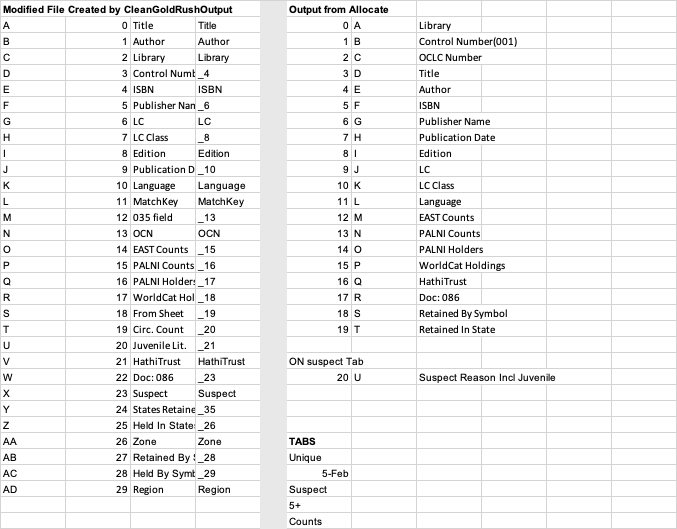

In [6]:
#@title SKIP updatePercent

%%skip

def updatePercent(libmetadata_dict, librarytoretain):
    # libname: 0:state,1:symbols,2:collection size 3:retentions,4:%,5:census zone 6:allocated,7:unique,8:topping,9:suspect,10:noOCN
    retentions = libmetadata_dict[librarytoretain][3]
    collectionsize = libmetadata_dict[librarytoretain][2]
    newpercent = int(retentions) / int(collectionsize)
    newpercent = retentions / collectionsize     # calculate new percent
    #print(librarytoretain, "OLD PERCENT:", libmetadata_dict[librarytoretain][4])
    libmetadata_dict[librarytoretain][4] = str(newpercent)  # update percent
    #print("row[2], NEW PERCENT:", libmetadata_dict[librarytoretain][4])

In [7]:
#@title SKIP Assign
def assign(zonesheldin, zonesretainedin, zone, toallocate, matchkey, libmetadata_dict, dataframes_two_five, library):

    #print(zonesheldin[zone].values()) # this seems to work, even if strings
    #print(min(zonesheldin[zone].values()))

    if library == "": # need to determine library to retain
        lowest_percent = min(zonesheldin[zone].values()) # find the lowest percent in the target zone
        libs_with_lowest_value = [key for key, value in zonesheldin[zone].items() if value == lowest_percent] # get keys with lowest percent
        random.shuffle(libs_with_lowest_value) # shuffle the lowest percent
        librarytoretain = libs_with_lowest_value[0] # take the random first one
    else:
        librarytoretain = library # just a single library holds this, that was passed in to assign

    try:
        row = toallocate[matchkey][librarytoretain] # this should always work but failed once
    except Exception as e:
        print("ERROR:", e)
        print("...on Matchkey:", matchkey)
        return

    dataframes_two_five[librarytoretain].loc[len(dataframes_two_five[librarytoretain].index)] = [row[2],row[3],row[13],row[0],row[1],row[4],row[5],row[9],row[8],row[6],row[7],row[10],row[14],row[15],row[17],row[18],row[19],row[20],row[26],row[23],row[25], row[22], row[24], row[27], row[12]]
    libmetadata_dict[row[2]][8] += 1 # increment topping up 2-5
    libmetadata_dict[row[2]][6] += 1 # increment allocated count for lib
    libmetadata_dict[row[2]][3] += 1 # increment retentions
    zonesretainedin[zone] += 1 # increment retained in zone

    #print(row[0])
    #print("TO RETAIN:", librarytoretain, " in :",zone, zonesheldin[zone])
    del zonesheldin[zone][librarytoretain]#  remove library from holdings in zone

    updatePercent(libmetadata_dict, librarytoretain)

    return


In [8]:
#@title SKIP Allocate
%%skip

def allocate(toallocate, dataframes_two_five, libmetadata_dict, states_dict):
    # libmetadata_dict: libname: 0:state,1:symbols,2:collection size 3:retentions,4:%, 5:census zone 6:allocated,7:unique,8:topping,9:suspect,10:noOCN

    count = 0
    for matchkey in toallocate: # foreach matchkey that needs allocation

        count += 1

        if (count + 1) % feedbackcounter == 0:
            current_date_time = datetime.fromtimestamp(time.time()) # Convert to a datetime object
            formatted_date_time = current_date_time.strftime('%Y-%m-%d %H:%M:%S') # Format as date and time
            print(f"processed {count + 1} rows: {formatted_date_time}")

        zonesheldin = {'North': {} , 'South' : {}} #dictionary of dictionary of holding libraries in each zone
        zonesretainedin = {'North': 0 , 'South' : 0} # how many already retained in each zone, set to zero
        deletethese = [] # libraries that already retain this matchkey

        samplelibrary = next(iter(toallocate[matchkey])) # just grabing a library to get the EAST count, assuming close enough even if OCN differences
        #print("sample libary", samplelibrary)
        #print(toallocate[matchkey][samplelibrary]);
        EASTCount = int(float(toallocate[matchkey][samplelibrary][14]))
        #EASTCount = toallocate[matchkey][samplelibrary][14]

        numberofholders = len(toallocate[matchkey])
        EASTNeeds = 5 - EASTCount
        retainedinstates = list(str(toallocate[matchkey][samplelibrary][22]).split(",")) # list of states matchkey retained in

        for state in retainedinstates: # count how many retained in each zone
            state = state.strip() # remove any whitespace in state
            if state == "nan": # skip not retained in any state, alternatively could have checked for east>0
                 #print(retainedinstates)
                 #print(toallocate[matchkey][samplelibrary][0])
                 continue
            zonesretainedin[states_dict[state]] += 1

        #print("NUMBER OF HOLDERS UPON ENTERY TO ALLOCATE TITLE:", numberofholders, toallocate[matchkey][samplelibrary][0])

        for library in toallocate[matchkey].keys(): #  check if already retained; get zone retained, zone holders, & %
            # check first that library doesn't already retain - if it does toss it out of the mix
            if str(toallocate[matchkey][library][25]) != "nan": # 25 is retentions - someone retains this
                libsymbols = libmetadata_dict[library][1].split() # some have multi symbols, e.g: TFW TF TFF TUFVT
                for sym in libsymbols:
                    if re.search(sym, toallocate[matchkey][library][25]): #print("Found Match")
                        deletethese.append(library) # delete these once we are outside the loop
            # get zone of holder and percent retained of holder and zone of current retentions
            percent = libmetadata_dict[library][4]
            zone = libmetadata_dict[library][5]
            zonesheldin[zone][library] = percent # count of number of copies in each zone and keep their percent
            #print(library, "is in", zone, "and retains this percent", percent)

        if deletethese: # found a lib with a retention, remove it from the mix
            for lib in deletethese:
                del toallocate[matchkey][lib] # remove from toallocate matchkey
                numberofholders = len(toallocate[matchkey]) # reset (decrements) number of holders

        if numberofholders == 0: # all holders already retained, move on
            continue # go on to next matchkey

        if EASTNeeds >= numberofholders: # we need more than are available, assign all
            for library in toallocate[matchkey].keys(): # assign all holders of the matchkey
                zone = libmetadata_dict[library][5] # update zone in this loop of libraries
                assign(zonesheldin, zonesretainedin, zone, toallocate, matchkey, libmetadata_dict, dataframes_two_five, library)

        else: # this is the main allocation section, starting at the while...
            #print("allocate")
            #print("number of holders", numberofholders, "number in EAST", EASTCount, "EAST Needs", EASTNeeds)
            #---------------allocating copies when more than needed available

            while EASTNeeds > 0:  # figure out how many needed for N or S
                RN = zonesretainedin["North"]
                RS = zonesretainedin["South"]
                HN = len(zonesheldin["North"])
                HS = len(zonesheldin["South"])

                if RN >= RS and HS > 0: # if more or equal in North, prefer south if avaliable
                    if HS > 1 and 'South Carolina State University' in zonesheldin["South"].keys():  # more than one south and one is SCSU, rm SCSU
                            del zonesheldin["South"]['South Carolina State University'] # remove 'South Carolina State University' if it is in the mix as per PASCAL preference
                    assign(zonesheldin, zonesretainedin, "South", toallocate, matchkey, libmetadata_dict, dataframes_two_five, "") # passed by reference, phew

                elif RN >= RS and HS == 0: # if more or equal in North, but no south available, assign all you can to N
                    assign(zonesheldin, zonesretainedin, "North", toallocate, matchkey, libmetadata_dict, dataframes_two_five, "") # passed by reference, phew

                elif RS > RN and HN > 0: # if more retained S than N, and N available, assign to N
                    assign(zonesheldin, zonesretainedin, "North", toallocate, matchkey, libmetadata_dict, dataframes_two_five, "") # passed by reference, phew

                elif RS > RN and HN == 0: # if more retained S than N retained, but no N available, assign to S
                    assign(zonesheldin, zonesretainedin, "South", toallocate, matchkey, libmetadata_dict, dataframes_two_five, "") # passed by reference, phew

                else:
                    print("ERROR - unaccounted for retention scenario", matchkey)

                EASTNeeds -= 1

    return

In [9]:
#@title setWidths
def setWidths(uniqueworksheet, toppingupworksheet, suspectworksheet, moretanfiveworksheet, fieldsworksheet, countsworksheet, comma_format, text_format):

    #bold = workbook2.add_format({'bold': True}) # Create a format object using the bold format
  # num_format property of the format to '@' for text, '#' for int


    uniqueworksheet.set_column('A:B', 20, text_format)
    uniqueworksheet.set_column('C:C', 15)
    uniqueworksheet.set_column('D:E', 25)
    uniqueworksheet.set_column('F:F', 15)
    uniqueworksheet.set_column('G:G', 25)
    uniqueworksheet.set_column('H:H', 12)
    uniqueworksheet.set_column('I:L', 10)
    uniqueworksheet.set_column('M:P', 9, text_format)
    uniqueworksheet.set_column('Q:Q', 10)
    uniqueworksheet.set_column('R:R', 9)
    uniqueworksheet.set_column('S:S', 15)
    uniqueworksheet.set_column('T:V', 20)
    uniqueworksheet.set_column('W:W', 10)
    uniqueworksheet.set_column('X:X', 15)
    uniqueworksheet.set_column('Y:Y', 40)

    toppingupworksheet.set_column('A:B', 20, text_format)
    toppingupworksheet.set_column('C:C', 15)
    toppingupworksheet.set_column('D:E', 25)
    toppingupworksheet.set_column('F:F', 15)
    toppingupworksheet.set_column('F:F', 15)
    toppingupworksheet.set_column('G:G', 25)
    toppingupworksheet.set_column('H:H', 12)
    toppingupworksheet.set_column('I:L', 10)
    toppingupworksheet.set_column('M:P', 9, text_format)
    toppingupworksheet.set_column('Q:Q', 10)
    toppingupworksheet.set_column('R:R', 9)
    toppingupworksheet.set_column('S:S', 15)
    toppingupworksheet.set_column('T:V', 20)
    toppingupworksheet.set_column('W:W', 10)
    toppingupworksheet.set_column('X:X', 15)
    toppingupworksheet.set_column('Y:Y', 40)

    suspectworksheet.set_column('A:B', 20, text_format)
    suspectworksheet.set_column('C:C', 15)
    suspectworksheet.set_column('D:E', 25)
    suspectworksheet.set_column('F:F', 15)
    suspectworksheet.set_column('G:G', 25)
    suspectworksheet.set_column('H:H', 12)
    suspectworksheet.set_column('I:L', 10)
    suspectworksheet.set_column('M:P', 9, text_format)
    suspectworksheet.set_column('Q:Q', 10)
    suspectworksheet.set_column('R:R', 9)
    suspectworksheet.set_column('S:S', 15)
    suspectworksheet.set_column('T:V', 20)
    suspectworksheet.set_column('W:W', 10)
    suspectworksheet.set_column('X:X', 15)
    suspectworksheet.set_column('Y:Y', 40)

    moretanfiveworksheet.set_column('A:B', 20, text_format)
    moretanfiveworksheet.set_column('C:C', 15)
    moretanfiveworksheet.set_column('D:E', 25)
    moretanfiveworksheet.set_column('F:F', 15)
    moretanfiveworksheet.set_column('G:G', 25)
    moretanfiveworksheet.set_column('H:H', 12)
    moretanfiveworksheet.set_column('I:L', 10)
    moretanfiveworksheet.set_column('M:P', 9, text_format)
    moretanfiveworksheet.set_column('Q:Q', 10)
    moretanfiveworksheet.set_column('R:R', 9)
    moretanfiveworksheet.set_column('S:S', 15)
    moretanfiveworksheet.set_column('T:V', 20)
    moretanfiveworksheet.set_column('W:W', 10)
    moretanfiveworksheet.set_column('X:X', 15)
    moretanfiveworksheet.set_column('Y:Y', 40)

    countsworksheet.set_column('A:I', 12, comma_format)  #

    fieldsworksheet.set_column('A:A', 20)
    fieldsworksheet.set_column('B:B', 20)
    fieldsworksheet.set_column('C:C', 0)

In [10]:
#@title Read in intial data to df, palni counts, drop header rows

# Define the column types in a dictionary
column_types = {
    'Control Number(001)': 'string',  # For string data
    #'EAST Counts': 'Int64'  # fails if it hits a header row, deleting those below
    'EAST Counts': 'string',
    'PALNI Counts': 'string'
}
print(infile)

df = pd.read_csv(infile, dtype=column_types)
#print(df.columns)

# if we are using all the ALL files might have some stray header rows, but
# if just using the one ALL PALNI this doesn't do anything/not needed
total_rows = len(df)
print("df w/ header rows: ", len(df))
Headers_to_drop = df[df['Library'].str.startswith('Library')].index
df.drop(index=Headers_to_drop, inplace=True)
print("df w/o header rows:", len(df))

# EAST counts is #.# or ?? and needs to be int
df['EAST Counts'] = pd.to_numeric(df['EAST Counts'], errors='coerce')
df['EAST Counts'] = df['EAST Counts'].round().astype('Int64')
df['PALNI Counts'] = pd.to_numeric(df['PALNI Counts'], errors='coerce')
df['PALNI Counts'] = df['PALNI Counts'].round().astype('Int64')
df['WorldCat Holdings'] = pd.to_numeric(df['WorldCat Holdings'], errors='coerce')
df['WorldCat Holdings'] = df['WorldCat Holdings'].round().astype('Int64')

df['Control Number(001)'] = df['Control Number(001)'].astype('string')

df['Juvenile Lit.'] = df['Juvenile Lit.'].replace('Y', 'Juvenile')

df.rename(columns={'OCN': 'OCLC Number', 'States Retained In': 'EAST Retained In State', 'Retained By Symbol': 'EAST Retained By Symbol', 'WorldCat Holdings': 'WorldCat Holdings Count', 'Doc: 086': 'Has MARC 086 Field'}, inplace=True)



/content/drive/MyDrive/Colab Notebooks/InputFiles/PALNI/ForALLFile_PALNI-ALL.csv
df w/ header rows:  2345994
df w/o header rows: 2345994


In [11]:
#@title SKIP Create summary dfs for PALNI and EAST counts by library - pre gemini fix
%%skip
#---PALNI overlap summary--#--Copy on Write is on by default in Pandas, so this works even when df desimated
PALNIsummary_df = df['PALNI Counts'].value_counts().reset_index()
PALNIsummary_df.columns = ['Held By', 'Copies']
PALNIsummary_df['Titles'] = PALNIsummary_df['Copies'] / PALNIsummary_df['Held By']
PALNIsummary_df = PALNIsummary_df.sort_values(by='Held By')
ptotals = PALNIsummary_df.sum(numeric_only=True)
ptotals["Held By"] = "Total"  # Label the totals row
PALNIsummary_df = pd.concat([PALNIsummary_df, pd.DataFrame([ptotals])], ignore_index=True)

print(PALNIsummary_df)

#---PALNI overlap by library--#--Copy on Write is on by default in Pandas, so this works even when df desimated
PALNIsummary_bylib_df = df.groupby('Library')['PALNI Counts'].value_counts().reset_index(name='Holdings')
PALNIsummary_bylib_df = PALNIsummary_bylib_df.pivot(index='Library', columns='PALNI Counts', values='Holdings').reset_index()
PALNIsummary_bylib_df = PALNIsummary_bylib_df.fillna(0)
plibtotals = PALNIsummary_bylib_df.sum(numeric_only=True)
PALNIsummary_bylib_df = pd.concat([PALNIsummary_bylib_df, pd.DataFrame([plibtotals])], ignore_index=True)

print(PALNIsummary_bylib_df)

#---EAST overlap summary--#--Copy on Write is on by default in Pandas, so this works even when df desimated
EASTsummary_bylib_df = df.groupby('Library')['EAST Counts'].value_counts().reset_index(name='Holdings')
EASTsummary_bylib_df = EASTsummary_bylib_df.pivot(index='Library', columns='EAST Counts', values='Holdings').reset_index()
EASTsummary_bylib_df = EASTsummary_bylib_df.fillna(0)
columns_to_combine = [col for col in EASTsummary_bylib_df.columns if isinstance(col, (int, float)) and col >= 5]

# Create the "5+" column as the sum of those columns
EASTsummary_bylib_df["5+"] = EASTsummary_bylib_df[columns_to_combine].sum(axis=1)

# Drop the old columns that were combined
EASTsummary_bylib_df = EASTsummary_bylib_df.drop(columns=columns_to_combine)

# Create a "Totals" column summing all numeric values
EASTsummary_bylib_df["Totals"] = EASTsummary_bylib_df.drop(columns=["Library"]).sum(axis=1)

# Compute percentages for each numeric column except "Totals"
percentage_cols = [col for col in EASTsummary_bylib_df.columns if col not in ["Library", "Totals"]]


for col in percentage_cols:
    EASTsummary_bylib_df[f"{col} %"] = ((EASTsummary_bylib_df[col] / EASTsummary_bylib_df["Totals"]) * 100).round().astype(int).astype(str) + "%"

# Reorder columns so that each % column follows its corresponding count column
ordered_columns = ["Library"]
for col in sorted(percentage_cols, key=lambda x: (isinstance(x, str), x)):  # Ensure order is numeric
    ordered_columns.append(col)
    if f"{col} %" in EASTsummary_bylib_df.columns:
        ordered_columns.append(f"{col} %")
ordered_columns.append("Totals")  # Ensure "Totals" is at the end

EASTsummary_bylib_df = EASTsummary_bylib_df[ordered_columns]  # Reorder the DataFrame to get 1 and 1% ...next to each other
EASTsummary_bylib_df = EASTsummary_bylib_df.drop(columns=['Totals']) # was just to get %s

###############CHARTS######################
# Melt the DataFrame to have a "Category" and "Percentage" column for stacking
df_melted = EASTsummary_bylib_df.melt(id_vars=['Library'], var_name='Category', value_name='Percentage')

# Convert percentage values to numeric by stripping "%" and converting to float
df_melted["Percentage"] = df_melted["Percentage"].str.rstrip("%").astype(float)

# Create stacked bar chart using Altair
chart = alt.Chart(df_melted).mark_bar().encode(
    x=alt.X('Percentage:Q', title="Percentage (%)", stack='normalize'),  # Normalize for 100% stacking
    y=alt.Y('Library:N', title="Library", sort='-x'),
    color=alt.Color('Category:N', title="Category"),
    tooltip=['Library', 'Category', 'Percentage']
).properties(
    title="EAST overlap by percent of titles submitted",
    width=600,
    height=400
)

# Display the chart
chart

## The following would create a stacked bar chart based on # of titles rather than percentages
# # Melt the DataFrame to have a "Number" and "Value" column for stacking
# df_melted = EASTsummary_bylib_df.melt(id_vars=['Library'], var_name='Number', value_name='Count')

# # Create stacked bar chart
# chart = alt.Chart(df_melted).mark_bar().encode(
#     x=alt.X('Count:Q', title="Count"),
#     y=alt.Y('Library:N', title="Library", sort='-x'),
#     color=alt.Color('Number:N', title="Category"),
#     tooltip=['Library', 'Number', 'Count']
# ).properties(
#     title="EAST Overlap by Library"
# )

# # Display the chart
# chart.show()

# rename columns
print(EASTsummary_bylib_df.columns)
EASTsummary_bylib_df = EASTsummary_bylib_df.rename(columns={0:'Unique to EAST', '0 %':'Percent Unique to EAST', \
                                      1:'1 Copy in EAST', '1 %':'Percent with one Holding in EAST',
                                      2:'2 Copies in EAST', '2 %':'Percent with two Holdings in EAST',
                                      3:'3 Copies in EAST', '3 %':'Percent with three Holdings in EAST',
                                      4:'4 Copies in EAST', '4 %':'Percent with four Holdings in EAST',
                                  '5+':'5+ Copies in EAST', '5+ %':'Percent with 5+ Holdings in EAST'
                                      })
#['Library', 0, '0 %', 1, '1 %', 2, '2 %', 3, '3 %', 4, '4 %', '5+', '5+ %'],
print(EASTsummary_bylib_df.columns)

In [12]:
#@title Create Summary dfs for PALNI counts by library

#---PALNI overlap summary--#--Copy on Write is on by default in Pandas, so this works even when df desimated
PALNIsummary_df = df['PALNI Counts'].value_counts().reset_index()
PALNIsummary_df.columns = ['Held By', 'Copies']
PALNIsummary_df['Titles'] = PALNIsummary_df['Copies'] / PALNIsummary_df['Held By']
PALNIsummary_df = PALNIsummary_df.sort_values(by='Held By')
ptotals = PALNIsummary_df.sum(numeric_only=True)

# Create a new DataFrame for the totals row with the correct data type for 'Held By'
ptotals_df = pd.DataFrame([ptotals])
ptotals_df['Held By'] = 'Totals'  # Now, 'Held By' is of object (string) dtype
# Concatenate the original DataFrame and the totals DataFrame
PALNIsummary_df = pd.concat([PALNIsummary_df, ptotals_df], ignore_index=True)
#print(PALNIsummary_df)

#---PALNI overlap by library--#--Copy on Write is on by default in Pandas, so this works even when df desimated
PALNIsummary_bylib_df = df.groupby('Library')['PALNI Counts'].value_counts().reset_index(name='Holdings')
PALNIsummary_bylib_df = PALNIsummary_bylib_df.pivot(index='Library', columns='PALNI Counts', values='Holdings').reset_index()
PALNIsummary_bylib_df = PALNIsummary_bylib_df.fillna(0)
plibtotals = PALNIsummary_bylib_df.sum(numeric_only=True)
# Create a new DataFrame for the totals row with correct data type
plibtotals_df = pd.DataFrame([plibtotals])
# Assume 'Library' is the column where you want to insert "Total"
plibtotals_df['Library'] = 'Totals'
PALNIsummary_bylib_df = pd.concat([PALNIsummary_bylib_df, plibtotals_df], ignore_index=True)
#print(PALNIsummary_bylib_df.columns)
print(PALNIsummary_bylib_df)


#---PALNI overlap by library--combining 3+ for use in making bar chart
# Select columns with headers greater than 2
pcolumns_to_combine = [col for col in PALNIsummary_bylib_df.columns if isinstance(col, (int, float)) and col > 2]
# Creating the new dataframe with the required format
#print(PALNIsummary_bylib_df.columns)

# Ensure the columns exist, filling with 0 if not, prevents error when testing with tiny data that might not have 1 or 2 PALNI overlap
for col in [1, 2]:
    if col not in PALNIsummary_bylib_df.columns:
        PALNIsummary_bylib_df[col] = 0
PALNIsummary_transformed_df = PALNIsummary_bylib_df[['Library', 1, 2]].copy() # will crash if no 2 overlaps palni....but abovie should fix it
# Summing values for columns greater than 2 into a new column '3+'
PALNIsummary_transformed_df['3+'] = PALNIsummary_bylib_df[pcolumns_to_combine].sum(axis=1)
PALNIsummary_transformed_df.drop(PALNIsummary_transformed_df[PALNIsummary_transformed_df["Library"] == "Totals"].index, inplace=True)

print(PALNIsummary_transformed_df)

###############CHARTS######################

## PALNI overlap chart
# Melting PALNIsummary_transformed dataframe for Altair compatibility
PALNIsummary_melted_df = PALNIsummary_transformed_df.melt(id_vars=['Library'], var_name='Category', value_name='Count')

# Creating the stacked bar chart with reversed axes
chart_palni = alt.Chart(PALNIsummary_melted_df).mark_bar().encode(
    y=alt.Y('Library:N', title='Library'),
    x=alt.X('Count:Q', title='Count', stack=True),
    color=alt.Color('Category:N', title='PALNI Overlap'),
    tooltip=['Library', 'Category', 'Count']
).properties(
    title="Overlap within PALNI by Library"
)

chart_palni.display()  # Display the first chart


PALNI Counts     Library       1       2       3       4       5       6  \
0                   AMBS   20028   14924   10961    8920    7145    5463   
1               Anderson   34369   19997   15776   12791   10535    8334   
2                 Bethel   21321   14768   10928    8664    6687    5315   
3                 Butler   39084   21407   14561   10629    7697    5708   
4                    CTS   46030   26201   16706   12200    8985    6754   
5                  CTSFW   38431   18127   12290    9522    7502    5753   
6                 DePauw   96142   49348   31861   21960   15083   10459   
7                Earlham   62117   34880   26178   20244   15680   11436   
8               Franklin   24081   14523   10669    8423    6767    4995   
9                    GCS   22760   12425    9070    7021    5524    4466   
10                Goshen    8872    5710    4510    3434    2820    2156   
11               Hanover   40112   27536   20545   15163   11216    8133   
12          

alt.Chart(...)

In [13]:
#@title Create Summary dfs for EAST counts by library
#---EAST overlap summary--#--Copy on Write is on by default in Pandas, so this works even when df desimated

### NOTE THAT BY DOING THIS HERE, SUSPECT TITLES ARE INCLUDED, WHEREAS THEY ARE EXCLUDE IN OTHER COUNTS
EASTsummary_bylib_df = df.groupby('Library')['EAST Counts'].value_counts().reset_index(name='Holdings')
EASTsummary_bylib_df = EASTsummary_bylib_df.pivot(index='Library', columns='EAST Counts', values='Holdings').reset_index()
EASTsummary_bylib_df = EASTsummary_bylib_df.fillna(0)
columns_to_combine = [col for col in EASTsummary_bylib_df.columns if isinstance(col, (int, float)) and col >= 5]

# Create the "5+" column as the sum of those columns
EASTsummary_bylib_df["5+"] = EASTsummary_bylib_df[columns_to_combine].sum(axis=1)

# Drop the old columns that were combined
EASTsummary_bylib_df = EASTsummary_bylib_df.drop(columns=columns_to_combine)

# sanity check here - if any of the columns for overlap, e.g. 1,2,3,4,5+ missing, as is sometimes the case w/ test data, add them
required_cols = [0, 1, 2, 3, 4, '5+']
if testing:
    print("EASTsummary_bylib_df before column add:", EASTsummary_bylib_df.columns)
#required_cols = ['0','1', '2', '3', '4', '5+', '0 %','1 %', '2 %', '3 %', '4 %', '5+ %']
for col in required_cols:
    if col not in EASTsummary_bylib_df.columns:
      print("Adding column:", col)
      EASTsummary_bylib_df[col] = 0 # make that column, fill with zero
      EASTsummary_bylib_df[col] = EASTsummary_bylib_df[col].fillna(0).astype(int) # make an int
if testing:
    print("EASTsummary_bylib_df after column add:", EASTsummary_bylib_df.columns)

#EASTsummary_bylib_df = EASTsummary_bylib_df[['Library','0','1','2','3','4','5+','Totals','0 %','1 %', '2 %', '3 %', '4 %', '5+ %']] # reorder with potentional new columns
EASTsummary_bylib_df = EASTsummary_bylib_df[['Library',0,1,2,3,4,'5+']] # reorder with potentional new columns
if testing:
  print("EASTsummary_bylib_df after column add sorting:", EASTsummary_bylib_df.columns)


# Create a "Totals" column summing all numeric values
EASTsummary_bylib_df["Totals"] = EASTsummary_bylib_df.drop(columns=["Library"]).sum(axis=1)

# Compute percentages for each numeric column except "Totals"
percentage_cols = [col for col in EASTsummary_bylib_df.columns if col not in ["Library", "Totals"]]
print("PERCENTAGE COLS:",percentage_cols)

for col in percentage_cols:
    EASTsummary_bylib_df[f"{col} %"] = ((EASTsummary_bylib_df[col] / EASTsummary_bylib_df["Totals"]) * 100).round().astype(int).astype(str) + "%"



# Calculate column totals for numeric columns and % averages for average columns
#print(EASTsummary_bylib_df.columns)
#['Library', 0, 1, 2, 3, 4,'5+', 'Totals', '0 %', '1 %', '2 %', '3 %','4 %', '5+ %'],
#  Compute column totals for 2st-6th column - 1:7 selects columns from index 1 (the second column) up to (but not including) index 7 (7th column)
# # note that the first column is now Library
etotals = EASTsummary_bylib_df.iloc[:, 1:7].sum()
# # Convert percentage from "#%" format to numeric (%s calculated in caluculate counts and percentages section)
epercentage_cols = EASTsummary_bylib_df.iloc[:, 8:14].replace('%', '', regex=True).astype(float) / 100
# # Compute column averages
eaverages = epercentage_cols.mean() * 100  # Convert back to percentage
# # Format averages as integers with "%" sign
eaverages = eaverages.round().astype(int).astype(str) + "%"
# # Combine totals and formatted averages into a new row - for the totals row
if testing:
    print("EASTsummary_bylib_df Columns:", EASTsummary_bylib_df.columns)
    #ipdb.set_trace()
# # etotal_avg_row will fail if not colums for 1, 2, 3, 4, 5, 6... check test data
etotal_avg_row = pd.DataFrame([['Total/Average'] + etotals.tolist() +  [''] + eaverages.tolist()],
                              columns=EASTsummary_bylib_df.columns)
#print(EASTsummary_bylib_df)
#print(etotal_avg_row)
# # Append the new row to the DataFrame
EASTsummary_bylib_df = EASTsummary_bylib_df._append(etotal_avg_row, ignore_index=True)

#############
# Reorder columns so that each % column follows its corresponding count column
ordered_columns = ["Library"]
for col in sorted(percentage_cols, key=lambda x: (isinstance(x, str), x)):  # Ensure order is numeric
    ordered_columns.append(col)
    if f"{col} %" in EASTsummary_bylib_df.columns:
        ordered_columns.append(f"{col} %")
ordered_columns.append("Totals")  # Ensure "Totals" is at the end
#print(percentage_cols)
print("ORDERED COLUMNS:", ordered_columns)

EASTsummary_bylib_df = EASTsummary_bylib_df[ordered_columns]  # Reorder the DataFrame to get 1 and 1% ...next to each other
EASTsummary_bylib_df = EASTsummary_bylib_df.drop(columns=['Totals']) # was just to get %s

###############CHARTS######################

## EAST overlap chart
# Melt the DataFrame to have a "Category" and "Percentage" column for stacking
df_melted = EASTsummary_bylib_df.melt(id_vars=['Library'], var_name='Category', value_name='Percentage')
df_melted = df_melted[df_melted['Category'].str.contains('%', na=False)][['Library', 'Category', 'Percentage']]
print("DFMELTED:\n", df_melted.columns)
print(df_melted[df_melted['Library'] == 'Earlham'])

#print(EASTsummary_bylib_df)

# # Convert percentage values to numeric by stripping "%" and converting to float
df_melted["Percentage"] = df_melted["Percentage"].str.rstrip("%").astype(float)

# # Convert percentage values to numeric by stripping "%" and converting to float
df_melted["Percentage"] = df_melted["Percentage"].astype(float)  # Assuming no "%" exists now



# Create stacked bar chart using Altair
chart_east = alt.Chart(df_melted).mark_bar().encode(
    y=alt.Y('Library:N', title='Library'),
    x=alt.X('Percentage:Q', title='Percentage', stack=True),  # Use 'Percentage' instead of 'Count'
    color=alt.Color('Category:N', title='EAST Overlap'),
    tooltip=['Library', 'Category', 'Percentage']
).properties(
    title="EAST Overlap by Percent of Titles Submitted",
    width=600,
    height=400
)

chart_east.display()  # Display the  east chart

########################################
# rename columns
EASTsummary_bylib_df = EASTsummary_bylib_df.rename(columns={0:'Unique to EAST', '0 %':'Percent Unique to EAST', \
                                      1:'1 Copy in EAST', '1 %':'Percent with 1 Holding in EAST',
                                      2:'2 Copies in EAST', '2 %':'Percent with 2 Holdings in EAST',
                                      3:'3 Copies in EAST', '3 %':'Percent with 3 Holdings in EAST',
                                      4:'4 Copies in EAST', '4 %':'Percent with 4 Holdings in EAST',
                                  '5+':'5+ Copies in EAST', '5+ %':'Percent with 5+ Holdings in EAST'
                                      })
##############

# add a blank row and then a note about suspect titles included in counts
blank_row = pd.DataFrame([[np.nan] * len(EASTsummary_bylib_df.columns)], columns=EASTsummary_bylib_df.columns)
suspect_row = pd.DataFrame([['Includes Suspect Titles in Counts'] + [np.nan] * (len(EASTsummary_bylib_df.columns) - 1)], columns=EASTsummary_bylib_df.columns)
EASTsummary_bylib_df = pd.concat([EASTsummary_bylib_df, blank_row, suspect_row], ignore_index=True)

#print(EASTsummary_bylib_df.columns)
print(EASTsummary_bylib_df)

PERCENTAGE COLS: [0, 1, 2, 3, 4, '5+']
ORDERED COLUMNS: ['Library', 0, '0 %', 1, '1 %', 2, '2 %', 3, '3 %', 4, '4 %', '5+', '5+ %', 'Totals']
DFMELTED:
 Index(['Library', 'Category', 'Percentage'], dtype='object')
     Library Category Percentage
32   Earlham      0 %        14%
82   Earlham      1 %        24%
132  Earlham      2 %         6%
182  Earlham      3 %         5%
232  Earlham      4 %         4%
282  Earlham     5+ %        47%


alt.Chart(...)

EAST Counts                            Library  Unique to EAST  \
0                                         AMBS           21250   
1                                     Anderson           23756   
2                                       Bethel           21873   
3                                       Butler           10244   
4                                          CTS           19554   
5                                        CTSFW           32258   
6                                       DePauw           26948   
7                                      Earlham           28614   
8                                     Franklin            9694   
9                                          GCS           20064   
10                                      Goshen            7254   
11                                     Hanover            8884   
12                                  Huntington           17219   
13                                         MHL            7921   
14        

<ipython-input-13-7659944afa66>:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  EASTsummary_bylib_df = pd.concat([EASTsummary_bylib_df, blank_row, suspect_row], ignore_index=True)


In [14]:
#@title make dictionaries of dataframes

libmetadata_dict = {} # map name to metadata
dataframes_more_than_five = {} # dictionary to store dataframes of more than 5
dataframes_suspect = {} # dictionary to store dataframes of suspect titles, both unique and 2-5
dataframes_unique = {} # dictionary to store dataframes of unique titles
dataframes_two_five = {} # dictionary to store dataframes of 2-5 titles - global for use in allocate
toallocate_dict = {} # dictionary to store to allocates

In [15]:
#@title Read in field definitions, libmetadata, (not currently make states_dict)

#libmetadata = '/content/drive/MyDrive/temp/ColabTest/Member_Metadata.xlsx';  #0:instID, 1:lib, 2:GRLibName, 3:State, 4:Sym, 5:CollSize, 6:Retentions, 7:%, 8:Type, 9:Zone, 10:Region
fields_df = pd.read_excel(fields, sheet_name='Field Definitions for PALNI', dtype=str) ## Read in field definitions
#states_df = pd.read_excel(libmetadata, sheet_name='Zones', dtype=str) ## Read in state to zone mappings
#states_dict = states_df.set_index('State')['Zone'].to_dict() # Make states to zone dict

In [16]:
#@title Read the EAST Libraries Metadata file, Add headers/column_names dataframes

# 0:inst_id, 1:GRLibName, 2:State, 3:Sym, 4:CollSize, 5:Retentions, 6:%, 7:MemberType, 8:Zone, 9:Region, 10:Alloc File Name, 11:URL, 12: FEMA, 13:Name in MEMDB, 14: cohort
libmetadata_df = pd.read_excel(libmetadata, sheet_name='PALNI', dtype=str) #
#libmetadata_df['# in Gold Rush (2022)'] = pd.to_numeric(libmetadata_df['# in Gold Rush (2022)'], errors='coerce').astype(pd.Int64Dtype()) # make these ints
#libmetadata_df['Est Collection Size'] = pd.to_numeric(libmetadata_df['Est Collection Size'], errors='coerce').astype(pd.Int64Dtype())

for index, row in libmetadata_df.iterrows():
    if (row['Name in Gold Rush Reports EAST'].startswith('Library')): # skip header row
        continue
    # 0:inst_id, 1:GRLibName, 2:State, 3:Sym, 4:CollSize, 5:Retentions, 6:%, 7:MemberType, 8:Zone, 9:Region, 10:Alloc File Name, 11:URL, 12: FEMA, 13:Name in MEMDB, 14: cohort
    #  0s at the end are for 5:'Suspect Count, 6:Unique Count, 7:2-5 Count, 8:5+ Count
    libmetadata_dict[row['Name in Gold Rush Reports EAST']] = [ row['Symbol'],row['Est Collection Size'],row['Allocation File Name'], row['FEMA Zone'], row['Name in Members xlsx'], 0,0,0,0  ]
    #column_names = (['Library', 'Control Number(001)', 'OCLC Number','Title','Author','ISBN','Publisher Name','Publication Date','Edition','LC','LC Class','Language','EAST Counts', 'PALNI Counts', 'PALNI Holders', 'WorldCat Holdings','HathiTrust','Doc: 086','Held By Symbols','Held In States','Retained By Symbol','Retained In State','Zone', 'Region','035 field'])

    column_names = (['Library', 'Control Number(001)', 'OCLC Number','Title','Author','ISBN','Publisher Name','Publication Date','Edition','LC','LC Class','Language','EAST Counts', 'PALNI Counts', 'PALNI Holders', 'WorldCat Holdings Count','HathiTrust','Has MARC 086 Field','EAST Retained By Symbol','EAST Retained In State'])
    column_names5plus = (['Library', 'Control Number(001)', 'OCLC Number','Title','Author','ISBN','Publisher Name','Publication Date','Edition','LC','LC Class','Language','EAST Counts', 'PALNI Counts', 'PALNI Holders', 'Indiana Holdings', 'WorldCat Holdings Count','HathiTrust','Has MARC 086 Field','EAST Retained By Symbol','EAST Retained In State'])

    suspect_column_names = column_names + ['Suspect']

    #Add headers/dataframs -
    dataframes_unique[row['Name in Gold Rush Reports EAST']]         = pd.DataFrame(columns=column_names)
    dataframes_two_five[row['Name in Gold Rush Reports EAST']]       = pd.DataFrame(columns=column_names)
    dataframes_more_than_five[row['Name in Gold Rush Reports EAST']] = pd.DataFrame(columns=column_names5plus)
    dataframes_suspect[row['Name in Gold Rush Reports EAST']]        = pd.DataFrame(columns=suspect_column_names)



In [17]:
#@title SKIP Read in and make df for noocnworksheet
%%skip

column_types = {
    'Control Number(001)': 'string',  # For string data
}
noOCN_df = pd.read_csv(infilenoocn, dtype=column_types) # read the no OCLC numbers infile and make a pandas dataframe - noOCN_df

total_noOCN = len(noOCN_df)

noOCN_df.rename(columns={'OCN': 'OCLC Number', 'States Retained In': 'Retained In State'}, inplace=True)

# another approach would be -> for lib in noOCN_df['Library'].unique():

groups = noOCN_df.groupby('Library')
for lib, row in groups:
  if lib.startswith('SC') or lib.startswith('Library'):
    continue

  #print("Name:", lib, "Row:", row)
  #print(type(row))
  #(row['Title'])
  #print(row['Library'])

  #print(row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,12]])
  rows_to_append = row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,12]]  #
  #print(type(rows_to_append)) #df
  #print( type( dataframes_NoOCN[lib])) #df

  #existing_df = pd.concat([existing_df, rows_to_append], ignore_index=True)
  #dataframes_NoOCN['Anderson University']
  dataframes_NoOCN[lib] = pd.concat([dataframes_NoOCN[lib], rows_to_append], ignore_index=True)


  #dataframes_NoOCN[row['Library']].loc[len(dataframes_NoOCN[row['Library']].index)] = rows_to_append.tolist()
  libmetadata_dict[lib][10] += len(rows_to_append)
  #libmetadata_dict[lib][10] += 1 # increment noOCN


print("items in noocn csv:", len(noOCN_df))
print("libraries in dataframes_NoOCN:", len(dataframes_NoOCN))

#print(len(dataframes_NoOCN['Bard College']))
#print((dataframes_NoOCN['Bard College']))

In [18]:
#@title SKIP drop rows that are SC or header rows or EAST already has 5
%%skip

print("length of DF before drop SC and EAST > 4:", len(df))
SC_to_drop = df[df['Library'].str.startswith('SC')].index #dropping SC and Library rows
df.drop(index=SC_to_drop, inplace=True)

greaterthan4East_df = df[ df['EAST Counts'] > 4 ].index
df.drop(index=greaterthan4East_df, inplace=True)

print("length of DF after drop SC and EAST > 4 :", len(df))

libmetadata_dict: 5:Suspect Count, 6:Unique Count, 7:2-5 Count, 8:5+ Count


In [19]:
#@title create filter - load up dataframes_more_than_five

addtoMore_than_Five_df = df[(df['EAST Counts'] > 4)]
addtoMore_than_Five_df = addtoMore_than_Five_df.astype(str)
addtoMore_than_Five_df.replace('nan', '', inplace=True)

print("len addtoMore_than_Five_df", len(addtoMore_than_Five_df)) #
Five2groups = addtoMore_than_Five_df.groupby('Library')
for lib, row in Five2groups:
  #print(row.columns)
  #ipdb.set_trace()
  rows_to_append = row.loc[:, column_names]

  # this is to avoid the FutureWarning that empty cells will, in the future, 'no longer exclude empty or all-NA columns when determining the result dtypes.'
  dataframes_more_than_five[lib] = dataframes_more_than_five[lib].astype(str)
  rows_to_append = rows_to_append.astype(str)

  dataframes_more_than_five[lib] = pd.concat([dataframes_more_than_five[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][8] += len(rows_to_append) # increment unique count for lib
  #libmetadata_dict[lib][6] += len(rows_to_append) # increment allocated count for lib
df.drop(index=addtoMore_than_Five_df.index, inplace=True) # remove these from the df before continuing
print("len w/o addtoMore_than_Five", len(df)) # if test assert 97


# print(df['Title']) # shouldn't have anything here - not accounted for above -- IF EASTCOUNT NAN


len addtoMore_than_Five_df 901346
len w/o addtoMore_than_Five 1444648


In [20]:
#@title create filter - load up dataframes_suspect
#-- put rows with suspect in suspect sheet --
df['Suspect'] = df['Suspect'].astype(str)

addtoSuspect_df = df[ df['Suspect'].str.contains('publisher|author|title', case=False, na=False)]

addtoSuspect_df = addtoSuspect_df.astype(str)
addtoSuspect_df.replace('nan', '', inplace=True)

print("len addtoSuspect_df pre Juvenile", len(addtoSuspect_df))
#print(addtoSuspect_df)

Suspectgroups = addtoSuspect_df.groupby('Library')
for lib, row in Suspectgroups: # select rows from input to output to suspect list
  rows_to_append = row.loc[:, suspect_column_names]

  # this is to avoid the FutureWarning that empty cells will, in the future, 'no longer exclude empty or all-NA columns when determining the result dtypes.'
  dataframes_suspect[lib] = dataframes_suspect[lib].astype(str)
  rows_to_append = rows_to_append.astype(str)

  dataframes_suspect[lib] = pd.concat([dataframes_suspect[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][5] += len(rows_to_append) # increment suspect count

df.drop(index=addtoSuspect_df.index, inplace=True) # remove these from the df before continuing

print("len w/o suspect", len(df)) # if test assert 41


len addtoSuspect_df pre Juvenile 233091
len w/o suspect 1211557


In [21]:
#@title create filter - Add Juvenile to dataframes_suspect
#
# since addtoSuspect is a view, be explicit and change in the df. modifying addtoSuspect gives warning
df.loc[df['Juvenile Lit.'].str.contains('Juvenile', case=False, na=False), 'Suspect'] = "Juvenile" # update suspect column

addtoSuspect_df = df[ df['Juvenile Lit.'].str.contains('Juvenile', case=False, na=False)]
#addtoSuspect_df['Suspect'] = "Juvenile" # reason for these should be Juvenile

addtoSuspect_df = addtoSuspect_df.astype(str)
addtoSuspect_df.replace('nan', '', inplace=True)

print("len addtoSuspect_df - adding Juvenile", len(addtoSuspect_df))
Suspectgroups = addtoSuspect_df.groupby('Library')

for lib, row in Suspectgroups: # select rows from input to output to suspect list
  rows_to_append = row.loc[:, suspect_column_names]

  # this is to avoid the FutureWarning that empty cells will, in the future, 'no longer exclude empty or all-NA columns when determining the result dtypes.'
  dataframes_suspect[lib] = dataframes_suspect[lib].astype(str)
  rows_to_append = rows_to_append.astype(str)

  dataframes_suspect[lib] = pd.concat([dataframes_suspect[lib], rows_to_append], ignore_index=True)
  dataframes_suspect[lib] = dataframes_suspect[lib].sort_values(by=['EAST Counts'])

  libmetadata_dict[lib][5] += len(rows_to_append) # increment suspect count
df.drop(index=addtoSuspect_df.index, inplace=True) # remove these from the df before continuing
print("len w/o suspect", len(df)) # if test assert 41




len addtoSuspect_df - adding Juvenile 23132
len w/o suspect 1188425


In [22]:
#@title create filter - load up dataframes_unique

#-- put rows unique rows in unique
addtoUnique0_df = df[(df['EAST Counts']==0)]
addtoUnique0_df = addtoUnique0_df.astype(str)
addtoUnique0_df.replace('nan', '', inplace=True)

print("len addtoUnique0_df", len(addtoUnique0_df)) # if test assert 6

Unique0groups = addtoUnique0_df.groupby('Library')
#print(Unique0groups['Marian']['PALNI Counts'])
#ipdb.set_trace()
for lib, row in Unique0groups:
  rows_to_append = row.loc[:, column_names]

  # this is to avoid the FutureWarning that empty cells will, in the future, 'no longer exclude empty or all-NA columns when determining the result dtypes.'
  dataframes_unique[lib] = dataframes_unique[lib].astype(str)
  rows_to_append = rows_to_append.astype(str)

  #ipdb.set_trace()
  dataframes_unique[lib] = pd.concat([dataframes_unique[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][6] += len(rows_to_append) # increment unique count for lib
  #libmetadata_dict[lib][6] += len(rows_to_append) # increment allocated count for lib
df.drop(index=addtoUnique0_df.index, inplace=True) # remove these from the df before continuing
print("len w/o addtoUnique0", len(df)) # if test assert



len addtoUnique0_df 287245
len w/o addtoUnique0 901180


In [23]:
#@title create filter - load up dataframes_two_five
#-- 2-4 EAST - topping up rows in two-five

# Using to_numeric() method with errors='coerce' to handle non-numeric values
#df['EAST Counts'] = pd.to_numeric(df['EAST Counts'], errors='coerce')
# Convert to integer and handle NaN values
#df['EAST Counts'] = df['EAST Counts'].fillna(0).astype(int) # fixes 2.0

addtoTwo_Five2_df = df[(df['EAST Counts'] > 0) & (df['EAST Counts'] < 5)]
addtoTwo_Five2_df = addtoTwo_Five2_df.astype(str)
addtoTwo_Five2_df.replace('nan', '', inplace=True)

print("len addtoTwo_Five2_df", len(addtoTwo_Five2_df)) #
Two_Five2groups = addtoTwo_Five2_df.groupby('Library')
for lib, row in Two_Five2groups:
  rows_to_append = row.loc[:, column_names]

  # this is to avoid the FutureWarning that empty cells will, in the future, 'no longer exclude empty or all-NA columns when determining the result dtypes.'
  dataframes_two_five[lib] = dataframes_two_five[lib].astype(str)
  rows_to_append = rows_to_append.astype(str)

  dataframes_two_five[lib] = pd.concat([dataframes_two_five[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][7] += len(rows_to_append) # increment unique count for lib
  #libmetadata_dict[lib][6] += len(rows_to_append) # increment allocated count for lib
df.drop(index=addtoTwo_Five2_df.index, inplace=True) # remove these from the df before continuing
print("len w/o addtoTwo_Five2", len(df)) # if test assert 97
#if testing:
  #assert len(addtoTwo_Five2_df) == 355
  #assert len(df) == 0 # should all have been assigned by now




len addtoTwo_Five2_df 853080
len w/o addtoTwo_Five2 48100


In [24]:
#@title SKIP create filtered sets -- updated above to parse into smaller cells
%%skip

#print(df.columns)
#print(dataframes_suspect['Adelphi University'].columns)

df.rename(columns={'OCN': 'OCLC Number', 'States Retained In': 'Retained In State'}, inplace=True)
#libdict: 0:state,1:symbols,2:collection size 3:retentions,4:%,5:census zone 6:allocated,7:unique,8:topping,9:suspect,10:noOCN

# #-- put rows with WC Holdings = Invalid in No OCN sheet --
# print("len w/ invalid", len(df))
# addtoNoOCN_df = df[df['WorldCat Holdings'].str.contains('Invalid OCLC Number', na=False)]

# NoOCNgroups = addtoNoOCN_df.groupby('Library')
# for lib, row in NoOCNgroups:
#   rows_to_append = row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,12,15]]  #
#   dataframes_NoOCN[lib] = pd.concat([dataframes_NoOCN[lib], rows_to_append], ignore_index=True)
#   libmetadata_dict[lib][10] += len(rows_to_append) # increment no OCN count
# df.drop(index=addtoNoOCN_df.index, inplace=True) # remove these from the df before continuing
# print("len invalid df:", len(addtoNoOCN_df))
# print("len df w/0 invalid", len(df))

#-- put rows with suspect in suspect sheet --
addtoSuspect_df = df[ df['Suspect'].str.contains('publisher|author|title', case=False, na=False)]
print("len addtoSuspect_df", len(addtoSuspect_df))
Suspectgroups = addtoSuspect_df.groupby('Library')
for lib, row in Suspectgroups:
  rows_to_append = row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,14,15,17,18,19,20,26,23,25,22,24,27,12,21]]  #
  dataframes_suspect[lib] = pd.concat([dataframes_suspect[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][9] += len(rows_to_append) # increment suspect count
df.drop(index=addtoSuspect_df.index, inplace=True) # remove these from the df before continuing
print("len w/o suspect", len(df)) # if test assert 41

#-- put rows unique rows in unique
addtoUnique0_df = df[ (df['From Sheet'].str.contains('Unique')) & (df['EAST Counts']==0)]
print("len addtoUnique0_df", len(addtoUnique0_df)) # if test assert 6

#sea here fussing with east count being blank and not zero in reports
# these report datatype is Int64, and at this point 0 is still printing
#print(addtoUnique0_df.dtypes)
#print(addtoUnique0_df.iloc[:1, 14])  # Print first 1 rows of the column to check

Unique0groups = addtoUnique0_df.groupby('Library')
for lib, row in Unique0groups:
  rows_to_append = row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,14,15,17,18,19,20,26,23,25,22,24,27,12]]  #
  dataframes_unique[lib] = pd.concat([dataframes_unique[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][7] += len(rows_to_append) # increment unique count for lib
  libmetadata_dict[lib][6] += len(rows_to_append) # increment allocated count for lib
df.drop(index=addtoUnique0_df.index, inplace=True) # remove these from the df before continuing
print("len w/o addtoUnique0", len(df)) # if test assert

#-- put unique matchkey but 2-4 EAST -  topping up rows in two-five
addtoTwo_Five_df = df[ (df['From Sheet'].str.contains('Unique')) & (df['EAST Counts'] > 0) & (df['EAST Counts'] < 5)] # Unique matchkey in this group and EAST needs another copy
print("len addtoTwo_Five_df", len(addtoTwo_Five_df)) # if test assert 2
Two_Fivegroups = addtoTwo_Five_df.groupby('Library')
for lib, row in Two_Fivegroups:
  rows_to_append = row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,14,15,17,18,19,20,26,23,25,22,24,27,12]]  #
  dataframes_two_five[lib] = pd.concat([dataframes_two_five[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][8] += len(rows_to_append) # increment unique count for lib
  libmetadata_dict[lib][6] += len(rows_to_append) # increment allocated count for lib
df.drop(index=addtoTwo_Five_df.index, inplace=True) # remove these from the df before continuing
print("len w/o addtoTwo_Five", len(df)) # if test assert 33

#-- put Two to Five in this group and zero EAST, allocate them all in two-five
addtoTwo_Five2_df = df[(df['From Sheet'].str.contains('Two-to-Five')) & (df['EAST Counts'] == 0) ] # Unique matchkey in this group and EAST needs another copy
print("len addtoTwo_Five2_df", len(addtoTwo_Five2_df)) # if test assert  3
Two_Five2groups = addtoTwo_Five2_df.groupby('Library')
for lib, row in Two_Five2groups:
  rows_to_append = row.iloc[:, [2,3,13,0,1,4,5,9,8,6,7,10,14,15,17,18,19,20,26,23,25,22,24,27,12]]  #
  dataframes_two_five[lib] = pd.concat([dataframes_two_five[lib], rows_to_append], ignore_index=True)
  libmetadata_dict[lib][8] += len(rows_to_append) # increment unique count for lib
  libmetadata_dict[lib][6] += len(rows_to_append) # increment allocated count for lib
df.drop(index=addtoTwo_Five2_df.index, inplace=True) # remove these from the df before continuing
print("len w/o addtoTwo_Five2", len(df)) # if test assert 30

#-- MayNeedToAllocate
addtoAllocate_df = df[df['From Sheet'].str.contains('Two-to-Five|MoreThanFive') & (df['EAST Counts'] <5) ] # have copies, need copies
print("len addtoAllocate_df", len(addtoAllocate_df)) # if test assert  30
toAllocategroups = addtoAllocate_df.groupby('MatchKey')
for matchkey, group in toAllocategroups:
  #library_dict = {library : row}
  #library_dict = {lib: group['Library'].tolist() for lib in group['Library'].unique()}

  for _, row in group.iterrows():
    library = row['Library']
    library_dict = {library : row}
    toallocate_dict[matchkey] = library_dict


df.drop(index=addtoAllocate_df.index, inplace=True) # remove these from the df before continuing
print("len w/o toAllocate", len(df)) # if test assert 30

print(df['Title']) # shouldn't have anything here - not accounted for above -- IF EASTCOUNT NAN




In [25]:
#@title SKIP call allocation
%%skip

#------------------------------------------------------------------------------------------------------------------------------
print("Starting to allocate multiple copies:", datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')) # Convert to a datetime object
print("Number of matchkeys needing allocation:", len(toallocate_dict))

allocate(toallocate_dict, dataframes_two_five, libmetadata_dict, states_dict)

In [26]:
#@title Calculate Counts and percents in libmetadata_dict

# print(libmetadata_dict)
# Data comes in as:
# 'AMBS': ['IME', nan, 'Anabaptist Mennonite Biblical Seminary.xlsx', 'Relatively Low', 'Anabaptist Mennonite Biblical Seminary', 0, 3, 1, 0], 'Anderson': ['IN ...
# data leaves with:
# libmetadata_dict: 5:Suspect Count, 6:Unique Count, 7:2-5 Count, 8:5+ Count 9: total records 10: %suspect, 11: %unique, 12: %>5, 13: %>5

for key, values in libmetadata_dict.items():
    last_four_sum = sum(values[-4:])  # Sum the last 4 numeric values
    values.append(last_four_sum)  # Append the total

    if values[5] > 0: # calculate suspect percent and append
      suspect_percentage = (values[5] / last_four_sum) * 100  # 5th position value divided by sum
    else:
      suspect_percentage = 0  # If total sum is 0, percentage should be 0

    if values[6] > 0: # calculate unique percent and append
      unique_percentage = (values[6] / last_four_sum) * 100  # 6th position value divided by sum
    else:
      unique_percentage = 0  # If total sum is 0, percentage should be 0

    if values[7] > 0: # calculate suspect percent and append
      lessThanFive_percentage = (values[7] / last_four_sum) * 100  # 6th position value divided by sum
    else:
      lessThanFive_percentage = 0  # If total sum is 0, percentage should be 0

    if values[8] > 0: # calculate suspect percent and append
      moreThanFive_percentage = (values[8] / last_four_sum) * 100  # 6th position value divided by sum
    else:
      moreThanFive_percentage = 0  # If total sum is 0, percentage should be 0

    values.append(f"{int(suspect_percentage)}%")  # Append suspect percentage as integer with '%' sign
    values.append(f"{int(unique_percentage)}%")  # Append unique percentage as integer with '%' sign
    values.append(f"{int(lessThanFive_percentage)}%")  # Append unique percentage as integer with '%' sign
    values.append(f"{int(moreThanFive_percentage)}%")  # Append unique percentage as integer with '%' sign

# Print updated dictionary
# for key, values in libmetadata_dict.items():
#     print(f"{key}: {values}")



In [27]:
#@title Shade Columns Def
def ShadeColumns(dfname, worksheetname, formatname):
# Apply shading to columns C,D,G,H - if not stripping - this is another option
    num_rows = len(dfname)  # Total number of rows
    for row in range(1, num_rows + 1):  # Start from row 1 to exclude header (row 0)
      for col in [2, 3, 6, 7]:  # Column indices for C, D, G and H (0-based index)
          worksheetname.write(row, col, dfname.iloc[row - 1, col], formatname)
      #worksheetname.write(row, 1, dfname.iloc[row - 1, 1], shaded_format)  # Column B (index 1)

In [ ]:
#@title Make spreadsheets

for lib in libmetadata_dict: #Allocation File Name

  outputfile = outputdir + libmetadata_dict[lib][2]

  counts_df = pd.DataFrame(libmetadata_dict[lib]).T # import the lib metadata list, transposed to columns
  counts_columns = ['Suspect', 'Unique in EAST', 'Up to Five Copies in EAST', 'More than Five Copies in EAST', 'Total Records Submitted', \
                    '% Suspect', "% Unique in EAST", "% Up to Five Copies in EAST", '% More than Five Copies in EAST']

  # libmetadata_dict: 5:Suspect Count, 6:Unique Count, 7:2-5 Count, 8:5+ Count 9: total records 10: %suspect, 11: %unique, 12: %>5, 13: %>5
  counts_df = counts_df.iloc[:, -9:] # keep just the last 9 columns
  counts_df.columns = counts_columns
  # reorder columns in counts sheet
  counts_df = counts_df[['Unique in EAST', '% Unique in EAST', 'More than Five Copies in EAST', '% More than Five Copies in EAST', \
                     'Suspect', '% Suspect', 'Up to Five Copies in EAST', "% Up to Five Copies in EAST", 'Total Records Submitted']]


  with pd.ExcelWriter(outputfile, engine='xlsxwriter') as writer: # create a excel writer object
        workbook  = writer.book

        #int_format = workbook.add_format({'num_format': '#'})
        #long_number_format = workbook.add_format({'num_format': '0'})
        #comma_format = workbook.add_format({'num_format': '#,###'}) # writes blank if number is zero
        comma_format = workbook.add_format({'num_format': '[=0]0;[>0]#,###'}) # thanks claude
        text_format = workbook.add_format({'num_format': '@'})
        shaded_format = workbook.add_format({'bg_color': '#F1F1F1'})  # Light gray background

        #bold_int_format = workbook.add_format({'num_format': '#', 'bold': True}) # this was just for testing

        #dataframes_unique[lib] = dataframes_unique[lib].astype(str)
        #dataframes_unique[lib].fillna('', inplace=True)
        #dataframes_unique[lib]['PALNI Counts'] = dataframes_unique[lib]['PALNI Counts'].astype(str).replace('<NA>', '') # works, below does them all
        dataframes_unique[lib] = dataframes_unique[lib].astype(str).replace('<NA>', '') # works


        dataframes_unique[lib].to_excel(writer, sheet_name="Unique", na_rep='',index=False, header=True, freeze_panes=(1,0)) # invalid file if cell starts with "=" and not an equation
        #ipdb.set_trace()
        dataframes_two_five[lib].to_excel(writer, sheet_name="Up to Five Copies", index=False, header=True, freeze_panes=(1,0)) # ' '
        dataframes_suspect[lib].to_excel(writer, sheet_name="Suspect", index=False, header=True, freeze_panes=(1,0))
        #dataframes_NoOCN[lib].to_excel(writer, sheet_name="No OCLC #", index=False, header=True, freeze_panes=(1,0))
        dataframes_more_than_five[lib].to_excel(writer, sheet_name="More than Five Copies", index=False, header=True, freeze_panes=(1,0))
        counts_df.to_excel(writer, sheet_name="Counts", index=False, header=True, freeze_panes=(1,0))
        fields_df.to_excel(writer, sheet_name="Field Definitions", index=False, header=False)

        # Access the XlsxWriter workbook and worksheet objects
        countsworksheet = writer.sheets['Counts']
        uniqueworksheet = writer.sheets['Unique']
        toppingupworksheet = writer.sheets['Up to Five Copies']
        suspectworksheet = writer.sheets['Suspect']
        morethanfiveworksheet = writer.sheets['More than Five Copies']
        #noocnworksheet = writer.sheets['No OCLC #']
        fieldsworksheet = writer.sheets['Field Definitions']

        # Set the column width
        setWidths(uniqueworksheet, toppingupworksheet, suspectworksheet, morethanfiveworksheet, fieldsworksheet, countsworksheet, comma_format, text_format)

        # Define a format for wrapped text
        header_format = workbook.add_format({'text_wrap': True, 'bold': True, 'bg_color': 'silver'}) # silver is #C0C0C0
        bold_format = workbook.add_format({'bold': True})
        # Apply the format to the header row
        for col_num, value in enumerate(dataframes_unique[lib].columns.values):
            uniqueworksheet.write(0, col_num, value, header_format) # making assumption that number of columns the same in all these sheets
            toppingupworksheet.write(0, col_num, value, header_format)
        for col_num, value in enumerate(dataframes_suspect[lib].columns.values):
            suspectworksheet.write(0, col_num, value, header_format)
        for col_num, value in enumerate(dataframes_more_than_five[lib].columns.values):
            morethanfiveworksheet.write(0, col_num, value, header_format)
        for col_num, value in enumerate(counts_df.columns.values):
            countsworksheet.write(0, col_num, value, header_format)

        # bold these cells in Field Definitions tab: A1, A8, A36, A42
        fieldsworksheet.write('A1', fields_df.iloc[0,0], bold_format) # [row, column] - index of 0
        fieldsworksheet.write('A8', fields_df.iloc[7,0], bold_format)
        fieldsworksheet.write('A32', fields_df.iloc[31,0], bold_format)
        #fieldsworksheet.write('A42', fields_df.iloc[41,0], bold_format)

        ShadeColumns(counts_df, countsworksheet, shaded_format)


In [ ]:
#@title Stripe Rows Def
def StripeRows(dfname, worksheetname, formatname):
  num_rows, num_cols = dfname.shape  # Get last row and last column
  last_col_letter = chr(65 + num_cols - 1)  # Convert column index to Excel letter (A, B, C, ...)

  # Define the range dynamically (starting from row 2 to skip headers)
  data_range = f"A2:{last_col_letter}{num_rows + 1}"  # Adjust row index (+1 for header row)

  # Apply conditional formatting only to rows with data
  worksheetname.conditional_format(data_range, {
        'type': 'formula',
        'criteria': '=MOD(ROW(),2)=0',
        'format': formatname
  })

In [ ]:
#@title Make Summary Sheet Counts and Summary.xlsx

summary_file = outputdir + "Summary.xlsx"

summary_counts_df = pd.DataFrame(libmetadata_dict).T
#print(summary_counts_df)

# libmetadata_dict: 5:Suspect Count, 6:Unique Count, 7:2-5 Count, 8:5+ Count 9: total records 10: %suspect, 11: %unique, 12: %>5, 13: %>5
summary_counts_df = summary_counts_df.iloc[:, -9:]  # keep just the last nine columns
summary_counts_columns = ['Suspect', 'Unique', 'Up to Five Copies in EAST', 'More than Five Copies in EAST', 'Total',\
                          '% Suspect', "% Unique", "% Up to Five Copies in EAST", '% More than Five Copies in EAST']
summary_counts_df.columns = summary_counts_columns

summary_counts_reset_df = summary_counts_df.reset_index() # takes the current index (row labels) of the DataFrame and turns it into a regular column.
summary_counts_reset_df.columns =  ['Library'] + summary_counts_columns

# Compute column totals for 2st-6th column - 1:5 selects columns from index 1 (the second column) up to (but not including) index 6 (the sixth column)
# note that the first column is now Library
totals = summary_counts_reset_df.iloc[:, 1:6].sum()

# Convert percentage from "#%" format to numeric (%s calculated in caluculate counts and percentages section)
percentage_cols = summary_counts_reset_df.iloc[:, 6:11].replace('%', '', regex=True).astype(float) / 100

# Compute column averages
averages = percentage_cols.mean() * 100  # Convert back to percentage

# Format averages as integers with "%" sign
averages = averages.round().astype(int).astype(str) + "%"

# Combine totals and formatted averages into a new row - for the totals row
total_avg_row = pd.DataFrame([['Total/Average'] + totals.tolist() + averages.tolist()],
                             columns=summary_counts_reset_df.columns)

# Append the new row to the DataFrame
summary_counts_reset_df = summary_counts_reset_df._append(total_avg_row, ignore_index=True)

#summary_counts_reset_df = summary_counts_reset_df.drop(columns="Total")

summary_counts_reset_df = summary_counts_reset_df[[ \
                          "Library", "Unique", "% Unique", "More than Five Copies in EAST", "% More than Five Copies in EAST",\
                          "Suspect", "% Suspect", "Up to Five Copies in EAST", "% Up to Five Copies in EAST", "Total"]]

summary_counts_reset_df = summary_counts_reset_df.rename(columns={'Total' : 'Total Records Submitted'})
#print(summary_counts_reset_df)

with pd.ExcelWriter(summary_file, engine='xlsxwriter') as writer2:
    workbook2  = writer2.book
    #workbook.set_default_charset('utf-8') # AI says XlsxWriter automatically handles UTF-8 encoding in newer versions.


    comma_format = workbook2.add_format({'num_format': '[=0]0;[>0]#,###'}) # thanks claude
    #text_format = workbook2.add_format({'num_format': '@'})

    summary_counts_reset_df.to_excel(writer2, sheet_name="Summary Counts", index=False, header=True, freeze_panes=(1,0)) #

    PALNIsummary_df.to_excel(writer2, sheet_name="PALNI Overlap", index=False, header=True, freeze_panes=(1,0))
    PALNIsummary_bylib_df.to_excel(writer2, sheet_name="PALNI Overlap by Library", index=False, header=True, freeze_panes=(1,0))
    EASTsummary_bylib_df.to_excel(writer2, sheet_name="EAST Overlap by Library", index=False, header=True, freeze_panes=(1,0))

    # set widths
    countsworksheet2 = writer2.sheets['Summary Counts']
    countsworksheet2.set_column('A:A', 20, comma_format)  # Column A:A width
    countsworksheet2.set_column('B:J', 15, comma_format)  #

    palnicountsworksheet = writer2.sheets['PALNI Overlap']
    palnicountsworksheet.set_column('A:A', 10)  # Column A:A width
    palnicountsworksheet.set_column('B:C', 10, comma_format)

    palnioverlapworksheet = writer2.sheets['PALNI Overlap by Library']
    palnioverlapworksheet.set_column('A:C', 10, comma_format)  # Column A:C width

    eastoverlapworksheet = writer2.sheets['EAST Overlap by Library']
    eastoverlapworksheet.set_column('A:A', 20, comma_format)  # Column A:A width
    eastoverlapworksheet.set_column('B:M', 15, comma_format)  #
    # Define formats
    header_format = workbook2.add_format({'text_wrap': True, 'bold': True, 'bg_color': 'silver'}) # silver is #C0C0C0
    bold = workbook2.add_format({'bold': True, 'num_format': '[=0]0;[>0]#,###'}) # Create a format object using the bold format
    shaded_format = workbook2.add_format({'bg_color': '#F1F1F1'})  # Light gray background

    # Apply the format to the header row
    for col_num, value in enumerate(summary_counts_reset_df.columns.values): # Summary Counts sheet
        countsworksheet2.write(0, col_num, value, header_format)  # Apply format to each header cell
    for col_num, value in enumerate(EASTsummary_bylib_df.columns.values): # Summary Counts sheet
        eastoverlapworksheet.write(0, col_num, value, header_format)  # Apply format to each header cell
    for col_num, value in enumerate(PALNIsummary_bylib_df.columns.values): # Summary Counts sheet
        palnioverlapworksheet.write(0, col_num, value, header_format)  # Apply format to each header cell
    for col_num, value in enumerate(PALNIsummary_df.columns.values): # Summary Counts sheet
        palnicountsworksheet.write(0, col_num, value, header_format)  # Apply format to each header cell
    # bold the final totals row
    countsworksheet2.set_row(len(summary_counts_reset_df), None, bold) # bold the final totals row
    eastoverlapworksheet.set_row( (len(EASTsummary_bylib_df)-2), None, bold) # bold totals row - 2 from end
    eastoverlapworksheet.set_row(len(EASTsummary_bylib_df), None, bold) # bold totals row - 2 from end
    palnicountsworksheet.set_row(len(PALNIsummary_df), None, bold) # bold the final totals row
    palnioverlapworksheet.set_row(len(PALNIsummary_bylib_df), None, bold) # bold the final totals row

  ### Stripe Rows #########
    StripeRows(summary_counts_reset_df, countsworksheet2, shaded_format)
    StripeRows(EASTsummary_bylib_df, eastoverlapworksheet, shaded_format)
    StripeRows(PALNIsummary_bylib_df, palnioverlapworksheet, shaded_format)
    StripeRows(PALNIsummary_df, palnicountsworksheet, shaded_format)


In [ ]:
#@title summary to screen

print("----Summary---")
# End the timer and report how long it took
end_time = time.time()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(len(df), " rows were left in input file")
if(len(df) !=0):
  #print(df)
  missingEast_file = outputdir + "zMissingEAST.xlsx"
  with pd.ExcelWriter(missingEast_file, engine='xlsxwriter') as writer3:
    workbook3  = writer3.book
    df.to_excel(writer3, sheet_name="Missing EAST", index=False, header=True, freeze_panes=(1,0))
    print("Missing EAST wrote to: ", missingEast_file)
print(total_rows, " rows were in input file")
##print(total_noOCN, " copies were in no OCN file")
#print("Already had 5 EAST:", len(greaterthan4East_df))

now = datetime.now()
pacific_tz = ZoneInfo('America/Los_Angeles')
now_pacific = now.astimezone(pacific_tz)
print(f"\nEnding at: {now_pacific.strftime('%Y-%m-%d %H:%M:%S')}")
#print("Ending at:", datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')) # Convert to a datetime object
print(f"Script took {minutes} minutes and {seconds} seconds to run.")


In [ ]:
#@title Bar chart example
%%skip
# load an example dataset
from vega_datasets import data
cars = data.cars()

# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(cars).mark_bar().encode(
  x=alt.X('Miles_per_Gallon', bin=True),
  y='count()',
  color='Origin'
)